<a href="https://colab.research.google.com/github/OrrAvrech/starter-project/blob/main/notebooks/train_video_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install -r "/content/drive/MyDrive/mia_starter_project/requirements.txt"
!apt install imagemagick -q

In [55]:
import random
import torch
import imageio
import wandb
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import Image
from ipywidgets import Output, GridspecLayout
from IPython import display
from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize
)
from torchvision.transforms._transforms_video import CenterCropVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    ShortSideScale
)

import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import MulticlassAccuracy

import numpy as np

In [4]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
  print(f"using gpu device {torch.cuda.current_device()}")
else:
  print("using cpu")

using gpu device 0


Set random seed for better reproducibility:

In [6]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## Data
The dataset is divided into 10 folders for each exercise.
`ActioClassificationDataset` basically maps folders into classes, and loads video chunks, according to `clip_duration = num_frames * sample_rate / vid.fps`, where `num_frames` and `sample_rate` are often determined by the parameters of the pre-trained model we are using.

In [7]:
project_dir = Path("/content/drive/MyDrive/mia_starter_project")
data_dir = project_dir / "dataset"
train_dir = data_dir / "train"
val_dir = data_dir / "validation_clean_sampled"

In [8]:
class ActionClassificationDataset(Dataset):
    def __init__(
        self,
        data_dir: Path,
        num_frames: int,
        sample_rate: int,
        random_sampler: bool,
        transform=None,
    ):
        self.data_dir = data_dir
        self.labels = sorted([sub.name for sub in data_dir.iterdir() if sub.is_dir()])
        self.num_classes = len(self.labels)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.labels)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.labels)}
        self.clips = []
        self.num_frames = num_frames
        self.sample_rate = sample_rate
        self.random_sampler = random_sampler
        self.transform = transform

        for cls in self.labels:
            class_dir = data_dir / cls
            for video_path in class_dir.glob("video/*.mp4"):
                self.clips.append((video_path, self.class_to_idx[cls]))

    def __len__(self) -> int:
        return len(self.clips)

    def __getitem__(self, idx) -> tuple[torch.float32, int]:
        video_path, label = self.clips[idx]

        with VideoFileClip(str(video_path)) as vid:
          clip_duration = self.num_frames * self.sample_rate / vid.fps
          subsample_fps = vid.fps / self.sample_rate

          # by default take the start
          start_time = 0
          # for training, random sample
          if self.random_sampler:
              start_time = random.uniform(0, vid.duration - clip_duration)
          end_time = start_time + clip_duration

          video_frames = list(vid.subclip(start_time, end_time).iter_frames(fps=subsample_fps))[
              : self.num_frames
          ]

        video_np = np.moveaxis(np.array(video_frames), [0, -1], [1, 0])
        video_data = {"video": torch.from_numpy(video_np), "audio": None}
        video_data = self.transform(video_data)
        inputs = video_data["video"]
        return inputs, label


### Params

In [9]:
# X3D Params
model_name = "x3d_xs"
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
model_transform_params = {
    "x3d_xs": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 4,
        "sampling_rate": 12,
    },
    "x3d_s": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 13,
        "sampling_rate": 6,
    },
    "x3d_m": {
        "side_size": 256,
        "crop_size": 256,
        "num_frames": 16,
        "sampling_rate": 5,
    }
}

# Data/Training Params
flip_p = 0.5
batch_size = 16
epochs = 15
lr = 1e-3

Build datasets. Standard transformation are being used. More augmentations for training can be explored later on.

In [10]:
config = model_transform_params[model_name]
config.update({"flip_p": flip_p,
                "batch_size": batch_size,
                "epochs": epochs,
                "lr": lr})

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    ShortSideScale(size=config["side_size"]),
                    CenterCropVideo(crop_size=(config["crop_size"], config["crop_size"])),
                    RandomHorizontalFlip(p=flip_p),
                ]
            ),
        ),
    ]
)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    ShortSideScale(size=config["side_size"]),
                    CenterCropVideo(crop_size=(config["crop_size"], config["crop_size"]))
                ]
            ),
        ),
    ]
)

train_ds = ActionClassificationDataset(data_dir=train_dir,
                                       num_frames=config["num_frames"],
                                       sample_rate=config["sampling_rate"],
                                       random_sampler=True,
                                       transform=train_transform)

val_ds = ActionClassificationDataset(data_dir=val_dir,
                                    num_frames=config["num_frames"],
                                    sample_rate=config["sampling_rate"],
                                    random_sampler=False,
                                    transform=val_transform)
num_classes = train_ds.num_classes
print(f"num classes: {num_classes}")
print(f"number of training samples: {len(train_ds)}, randomly sample a window on each epoch")
print(f"number of validation samples: {len(val_ds)}")

num classes: 10
number of training samples: 228, randomly sample a window on each epoch
number of validation samples: 272


By using an inverse normilzation class, we can easily visualize the videos for training after all transformations, except scaling and normalization.

In [11]:
class InverseNormalize(Normalize):
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + torch.finfo(torch.float32).eps)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


def inv_transform(sample):
  inv_transform = Compose([InverseNormalize(mean, std),
                           Lambda(lambda x: torch.clip((x * 255.0).to(torch.uint8), min=0, max=255)),
                           Lambda(lambda x: x.permute(1, 2, 3, 0))])
  sample_np = inv_transform(sample).detach().cpu().numpy()
  return sample_np

 Visualize training sample. Notice that since `random_sampler=True` for the training dataset, each sample will randomly start from some time on each run.

In [12]:
sample = train_ds[0]
sample_video = sample[0]
label = sample[1]
print(train_ds.idx_to_class[label])
print(val_ds.class_to_idx)
print(train_ds.class_to_idx)

sample_video = inv_transform(sample_video)
clip = ImageSequenceClip(list(sample_video), fps=5)
clip.ipython_display()

ballet
{'ballet': 0, 'golf swing': 1, 'hitting baseball': 2, 'push ups': 3, 'sidekick': 4, 'slacklining': 5, 'squats': 6, 'strumming guitar': 7, 'swimming': 8, 'yoga': 9}
{'ballet': 0, 'golf swing': 1, 'hitting baseball': 2, 'push ups': 3, 'sidekick': 4, 'slacklining': 5, 'squats': 6, 'strumming guitar': 7, 'swimming': 8, 'yoga': 9}
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [14]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=8)

## Modeling
X3D transfer learning model, where a Kinetics400 pre-trained model is load from Pytorch Hub. Then, the last fully connected is removed and replaced by a randomly initialized fully connected layer with 10 neurons for 10 classes.

In [15]:
class LitX3DTransfer(pl.LightningModule):
    def __init__(self, model_name: str, num_classes: int):
        super().__init__()
        self.model_name = model_name
        model = torch.hub.load("facebookresearch/pytorchvideo", model_name, pretrained=True)
        layers = list(model.blocks.children())
        # feature extractor
        backbone = layers[:-1]
        self.feature_extractor = nn.Sequential(*backbone)
        # classifier
        self.fc = layers[-1]
        num_filters = self.fc.proj.in_features
        self.num_classes = num_classes
        self.fc.proj = nn.Linear(in_features=num_filters, out_features=num_classes, bias=True)

    def forward(self, x):
        representations = self.feature_extractor(x)
        predictions = self.fc(representations)
        return predictions

    def training_step(self, batch, batch_idx):
        x, y = batch
        self.feature_extractor.eval()
        with torch.no_grad():
          x = self.feature_extractor(x)
        y_hat = self.fc(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)

        artifacts = {"loss": loss,
                     "acc": acc}

        self.log("train_acc", acc, prog_bar=True, on_epoch=True)
        self.log("train_loss", loss.item(), prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)

        artifacts = {"loss": loss,
                     "acc": acc}

        self.log("val_acc", acc, prog_bar=True)
        self.log("val_loss", loss.item(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=lr)

    @staticmethod
    def accuracy(predictions, labels):
        classes = torch.argmax(predictions, dim=1)
        mean_acc = torch.mean((classes == labels).float())
        return mean_acc

## Training



In [16]:
x3d = LitX3DTransfer(model_name=model_name, num_classes=num_classes)

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_XS.pyth" to /root/.cache/torch/hub/checkpoints/X3D_XS.pyth
100%|██████████| 29.4M/29.4M [00:00<00:00, 37.1MB/s]


In [ ]:
early_stop_cb = pl.callbacks.EarlyStopping(monitor="val_loss")
model_ckpt_cb = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")
wandb_logger = pl.loggers.WandbLogger(project="mia-starter-project", log_model="all")

trainer = pl.Trainer(max_epochs=epochs, callbacks=[early_stop_cb, model_ckpt_cb], logger=wandb_logger)
trainer.fit(model=x3d, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
wandb.finish()

## Analysis

### Retrieve Inference Model
Loading the best model from W&B. Project page on W&B can be found [here](https://wandb.ai/orravrech/mia-starter-project/workspace?workspace=user-orravrech).

In [17]:
api = wandb.Api()
artifact = api.artifact('orravrech/mia-starter-project/model-td7lud2w:v8', type='model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
ckpt_path = Path(artifact_dir) / "model.ckpt"
ckpt = torch.load(ckpt_path, map_location=device)
infer_model = LitX3DTransfer(model_name, num_classes)
infer_model.load_state_dict(ckpt["state_dict"])
infer_model.eval()

In [ ]:
all_preds, all_labels, all_inputs = [[] for _ in range(3)]
with torch.no_grad():
  for inputs, labels in val_loader:
    inputs.to(device)
    outputs = infer_model(inputs)
    _, preds = torch.max(outputs, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    all_inputs.extend(inputs.cpu())

val_preds = torch.Tensor(all_preds)
val_labels = torch.Tensor(all_labels)

### Results
Next, we'll plot a confusion matrix over the entire validation set, as well as the per class accuracy.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

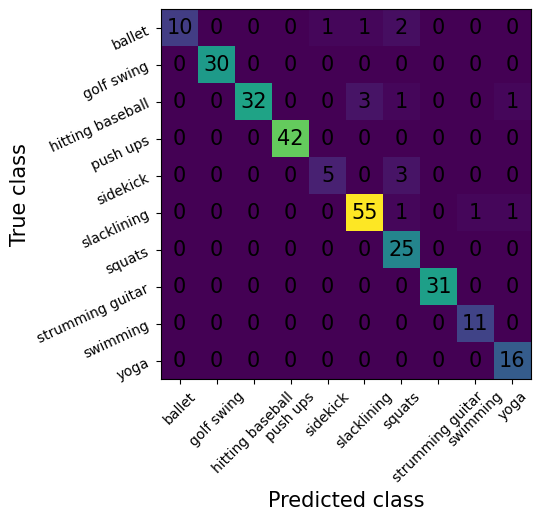

In [20]:
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
conf_matrix(val_preds, val_labels)
conf_matrix.plot(labels=val_ds.labels)

From the confusion matrix, we notice that `slacklining` and `squats` are the most "confusing" classes. Meaning, a miss is most likely to predict one of these classes. This might be due to a large occurrence of noisy segments in those classes (e.g, closeup on speaker) and the large variance in the surrounding scene. For example, a golf swing will most likely occur in a golf course. However, a squat video can be taken in a gym, outdoors or in someone's appartment.

In [21]:
macc = MulticlassAccuracy(num_classes=num_classes, average=None)
macc_res = macc(val_preds, val_labels).tolist()
_ = [print(f"{cls}:{prob}") for cls, prob in zip(val_ds.labels, macc_res)]

ballet:0.7142857313156128
golf swing:1.0
hitting baseball:0.8648648858070374
push ups:1.0
sidekick:0.625
slacklining:0.9482758641242981
squats:1.0
strumming guitar:1.0
swimming:1.0
yoga:1.0


### Misses
It would be interesting to visualize the misses of the underperforming classes- `ballet`, `hitting baseball` and `sidekick`.
Sidekick and Ballet are relatively scarce after cleaning the validation set with the zero-shot classification. This issue is further discussed in [Weaknesses & Future Work](https://colab.research.google.com/drive/1fII7W5zYVneJM4RtNEeN-qjIjONhqzMj#scrollTo=NJV5o_b0vjpN).

In [64]:
def get_fn_indices(val_preds, val_labels, cls_to_examine, cls_to_idx_map):
  idx_to_examine = cls_to_idx_map[cls_to_examine]
  target_labels = (val_labels == idx_to_examine).nonzero(as_tuple=True)[0]
  fn = (val_preds[target_labels] != idx_to_examine).nonzero(as_tuple=True)[0]
  fn_indices = target_labels[fn]
  return fn_indices


def save_fn_videos(val_preds, label_cls, input_list, fn_indices, idx_to_cls_map):
  outputs = []
  for i, sample_video, in enumerate(all_inputs):
    if i in fn_indices:
      sample_video = inv_transform(sample_video)
      pred_idx = int(val_preds[i])
      pred_cls = idx_to_cls_map[pred_idx]

      clip = ImageSequenceClip(list(sample_video), fps=5)
      filepath = f"{label_cls}_{i}.mp4"
      clip.write_videofile(filepath, logger=None)
      outputs.append((filepath, label_cls, pred_cls))
  return outputs


def plot_grid(val_preds, val_labels, input_list, label_cls):
  fn_indices = get_fn_indices(val_preds, val_labels, label_cls, cls_to_idx_map=val_ds.class_to_idx)
  fn_outputs = save_fn_videos(val_preds, label_cls, input_list, fn_indices, idx_to_cls_map=val_ds.idx_to_class)

  grid = GridspecLayout(1, len(fn_outputs))
  for i, (filepath, label, pred) in enumerate(fn_outputs):
    out = Output()
    with out:
        display.display(display.Video(filepath, embed=True, html_attributes="controls muted autoplay"))
        print(f"label: {label}\npred: {pred}")
    grid[0, i] = out
  return grid

In [66]:
cls_to_examine = "ballet"
plot_grid(val_preds, val_labels, all_inputs, cls_to_examine)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [65]:
cls_to_examine = "hitting baseball"
plot_grid(val_preds, val_labels, all_inputs, cls_to_examine)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [67]:
cls_to_examine = "sidekick"
plot_grid(val_preds, val_labels, all_inputs, cls_to_examine)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

### Weaknesses & Future Work
- ***Cleaning process too strict:*** using zero-shot video classification with XCLIP actually filtered out large amounts of "good" data in some classes (e.g `sidekick`). Perhaps steps/insturctions-video or steps/insturctions-narrations-video alignment methods would yield better results in terms of cleaning noisy segments from the data.
- ***Unbalanced test data due to the cleaning process:*** One issue that comes with the cleaning process, is that it may unbalance the data. Meaning, if in the video scraping step we made sure to obtain at least an hour per exercise, after the cleaning process we might have very different aggregations for the different exercises, because we rely on the performance of our zero-shot classification model.
-  Several of the chosen exercises are not ideal. For example:
  - ***Sidekick***: has a different meaning in various domains. For instance, apparently there's also a "sidekick" shot in Golf.
  - ***Swimming***: sometimes the demonstartion of the action is taking place outside the water, which makes it more difficult to align.
  - ***Strumming Guitar***: can be interesting if the audio signal is also added to the mix. Otherwise, there are probably better exercises to choose from.